# Key Estimation in Symbolic Music using Trajectories

In this notebook we investigate how to use the harmonic trajectory to predict the key.
It follows the section 3.2 of the dissertation.

In [10]:
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display, sklearn, ast, random, copy, music21
import networkx as nx
import numpy as np
from tqdm import tqdm

from TrajectoryCalculationsWithClass import NewTrajectory
from graph_creation import createGrakel, createNX
from FirstNotePosition import PlaceFirstNote

Definition of Basic functions for chord retrieval from symbolic score

In [1]:
def get_chords(parsed_midi):
    mChords = parsed_midi.chordify()
    chordList = []
    for c in mChords.recurse().getElementsByClass('Chord'):
        chordList.append(c.orderedPitchClasses)    
    N = len(chordList)
    chordListNoDoubles = []
    sl = [str(i) for i in chordList]
    chordListNoDoubles.append(chordList[0])
    for i in range(1, N):
        if sl[i] != sl[i - 1]:
            chordListNoDoubles.append(ast.literal_eval(sl[i]))
    return chordListNoDoubles

from IPython.core.display import display, HTML, Javascript
import json, random
def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)
    
def showMusicXML(xml):
    DIV_ID = "OSMD-div-"+str(random.randint(0,1000000))
    #print("DIV_ID", DIV_ID)
    msg='loading OpenSheetMusicDisplay'
    msg=''
    display(HTML('<div id="'+DIV_ID+'">{}</div>'.format(msg)))
    
    #print('xml length:', len(xml))

    script = """
    console.log("loadOSMD()");
    function loadOSMD() { 
        return new Promise(function(resolve, reject){

            if (window.opensheetmusicdisplay) {
                console.log("already loaded")
                return resolve(window.opensheetmusicdisplay)
            }
            console.log("loading osmd for the first time")
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object 
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.3.1/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                console.log("loaded OSMD for the first time",opensheetmusicdisplay)
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        }) 
    }
    loadOSMD().then((OSMD)=>{
        console.log("loaded OSMD",OSMD)
        var div_id = "{{DIV_ID}}";
            console.log(div_id)
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id);
        openSheetMusicDisplay
            .load({{data}})
            .then(
              function() {
                console.log("rendering data")
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('{{DIV_ID}}',DIV_ID).replace('{{data}}',json.dumps(xml))
    display(Javascript(script))
    return DIV_ID

In [25]:
tonnetz = [3, 4, 5]

#Parse MIDI file
m = music21.converter.parse("Midi_files/midi_export.mid")

chordlist_midi = get_chords(m)
trajectory_midi = NewTrajectory(chordlist_midi, tonnetz, PlaceFirstNote(chordlist_midi, tonnetz))
G = createNX(trajectory_midi)

key = m.analyze('key')
print(key.tonic.name, key.mode)

A minor


Various Visualisations of Data

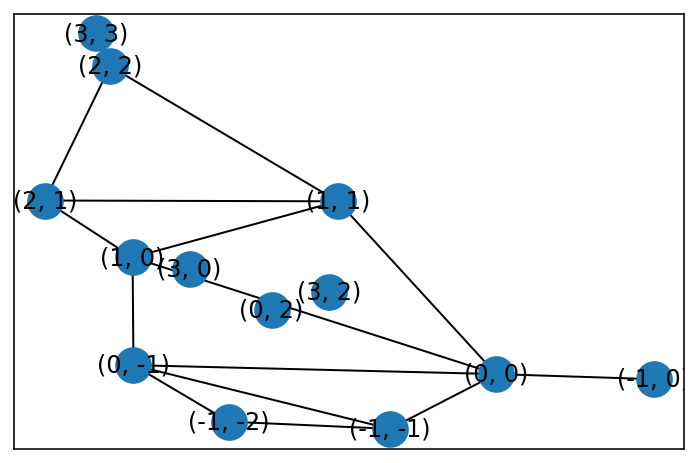

In [45]:
pos = nx.kamada_kawai_layout(G)
# labels = nx.draw_networkx_labels(G, pos)
nx.draw_networkx(G, pos=pos, with_labels=True)

In [22]:
showScore(m)

<IPython.core.display.Javascript object>